# Detecting Gravitional Waves Using Topological algorithms

Authors:
* Christian Jaffé Alarcón Acosta - A00832881
* José Andrés Orantes Guillén - A01174130
* Juan José Montes Raygoza - A00834630
* Pedro Fernández Merino - A01733006
* Rubén Darío Castro Terrazas - A00833945



### Import libraries and dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from data.generate_datasets import make_gravitational_waves
from pathlib import Path
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.cm as cm
import gudhi as gd
from sklearn.decomposition import PCA
from nolitsa import dimension, delay
from gtda.plotting import plot_point_cloud
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
import matplotlib.patches as patches
plt.rcParams.update(plt.rcParamsDefault) #Permitir Latex
import kmapper as km
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

sb.set(style="whitegrid")


### Motivation


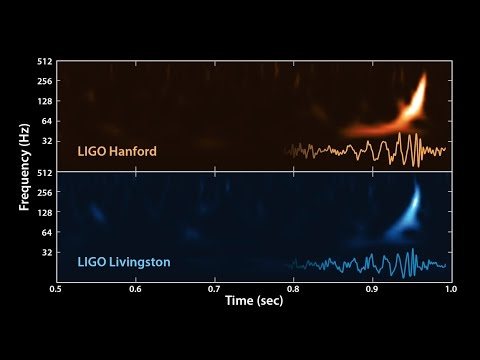

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo("Y3eR49ogsF0", width=600, height=400)
YouTubeVideo("QyDcTbR-kEA", width=600, height=400)

### Generate the data

The data was obtanined from the giotto-tda library: https://github.com/giotto-ai/giotto-tda/blob/master/examples/gravitational_waves_detection.ipynb

In the article, the authors create a synthetic training set as follows: 

* Generate gravitational wave signals that correspond to non-spinning binary black hole mergers
* Generate a noisy time series and embed a gravitational wave signal with probability 0.5 at a random time.

The result is a set of time series of the form

$$ s = g + \epsilon \frac{1}{R}\xi $$

where $g$ is a gravitational wave signal from the reference set, $\xi$ is Gaussian noise, $\epsilon=10^{-19}$ scales the noise amplitude to the signal, and $R \in (0.075, 0.65)$ is a parameter that controls the signal-to-noise-ratio (SNR).

In [37]:

R = 0.65
n_signals = 100
DATA = Path("./data")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


Plot the data (gravitational waves)

In [38]:
# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

In [32]:
#generar datos sintéticos con distintos valores de R

n_signals = 100
n = 100  # Define el número de iteraciones
DATA = Path("./data")

# Genera una lista de números aleatorios únicos entre 0.075 y 0.65
R_values = np.random.uniform(0.075, 0.65, n)
np.random.shuffle(R_values)

# Listas para almacenar los datos
ts_noise_list = []
ts_background_list = []
ts_signal_list = []

for i in range(n):  # Usa n en lugar de n_signals
    R = R_values[i]
    noisy_signals, gw_signals, labels = make_gravitational_waves(
        path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
    )

    # Obtener el índice correspondiente a la primera serie temporal de ruido puro
    background_idx = np.argmin(labels)
    # Obtener el índice correspondiente a la primera serie temporal de ruido + onda gravitacional
    signal_idx = np.argmax(labels)

    ts_noise = noisy_signals[background_idx]
    ts_background = noisy_signals[signal_idx]
    ts_signal = gw_signals[signal_idx]

    # Guardar los datos en las listas
    ts_noise_list.append(ts_noise)
    ts_background_list.append(ts_background)
    ts_signal_list.append(ts_signal)


# Convertir las listas a arrays de numpy
ts_noise_array = np.array(ts_noise_list)
ts_background_array = np.array(ts_background_list)
ts_signal_array = np.array(ts_signal_list)

# Guardar los arrays en archivos numpy
np.save(DATA / "ts_noise.npy", ts_noise_array)
np.save(DATA / "ts_background.npy", ts_background_array)
np.save(DATA / "ts_signal.npy", ts_signal_array)

In [5]:
gw_signals[0]

array([ 1.71223261e-22, -5.33559520e-22, -2.16195790e-22, ...,
        3.99231527e-22,  1.68263427e-22,  1.90632034e-22])

### Encaje de Takens

#### Parámetros óptimos de $\tau$ y $d$

* $\tau$: tiempo de retardo
* $d$: dimensión 

In [6]:
ts_noise.shape #dimension de los datos con ruido
max_parameters =  int(round(np.sqrt(ts_noise.shape[0]),0))
max_parameters

93

In [7]:
def find_optimal_delay(x, maxtau):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)
    return int(np.where(diffmi > 0)[0][0]) #returns the first element in which the difference is greater than 0. It means that gives you the local optimal
    #print(np.where(diffmi > 0))

In [8]:
tau_ts_noise  = find_optimal_delay(ts_noise,maxtau=max_parameters) #ejemplo
tau_ts_signal  = find_optimal_delay(ts_signal,maxtau=max_parameters) #ejemplo
print(f'El óptimo local para los datos con ruido es : {tau_ts_noise}')
print(f'El óptimo local para los datos sin ruido es : {tau_ts_signal}')

El óptimo local para los datos con ruido es : 1
El óptimo local para los datos sin ruido es : 21


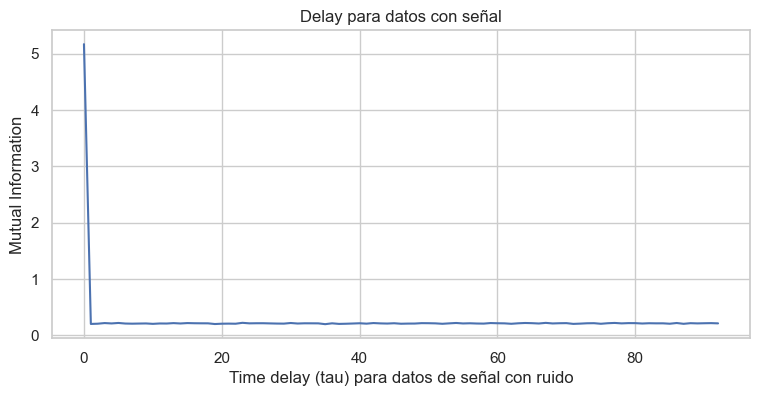

In [9]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau) para datos de señal con ruido')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(ts_noise, maxtau=max_parameters))
plt.title("Delay para datos con señal")
plt.show()

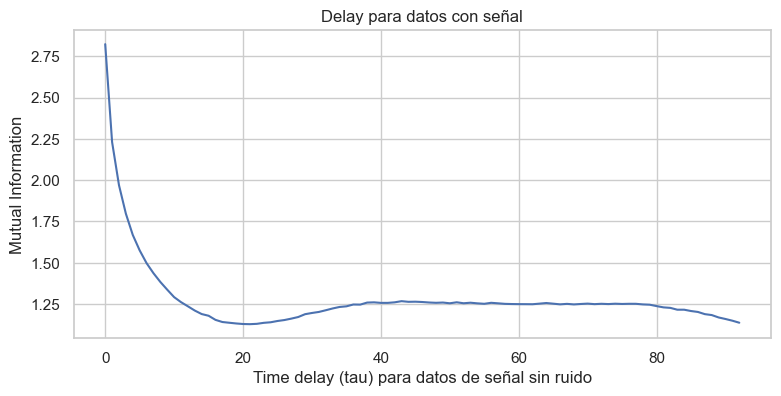

In [10]:
#sin ruido
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau) para datos de señal sin ruido')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(ts_signal, maxtau=max_parameters))
plt.title("Delay para datos con señal")
plt.show()

In [11]:
def find_optimal_dimension(y,tau):
    dim =  np.arange(1,10)
    f1, f2, f3 = dimension.fnn(y, tau=tau, dim=dim)
    diff_f1 = np.diff(f1)
    #print(f1)
    optimal_d = int(np.where(diff_f1 == 0)[0][0]) 

    #changeOf_diff_f1 = np.diff(diff_f1) 
    #optimal_dimension = np.argmax(changeOf_diff_f1) + 2
    return optimal_d


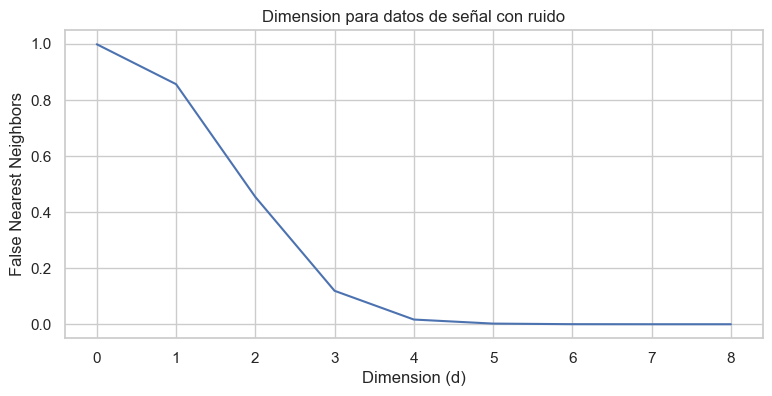

d:  7


In [12]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(ts_noise, tau=tau_ts_noise, dim=dim) #Ejemplo

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors')
plt.title("Dimension para datos de señal con ruido")
plt.plot(f1)
plt.show()
print("d: ",find_optimal_dimension(ts_noise,tau_ts_noise))

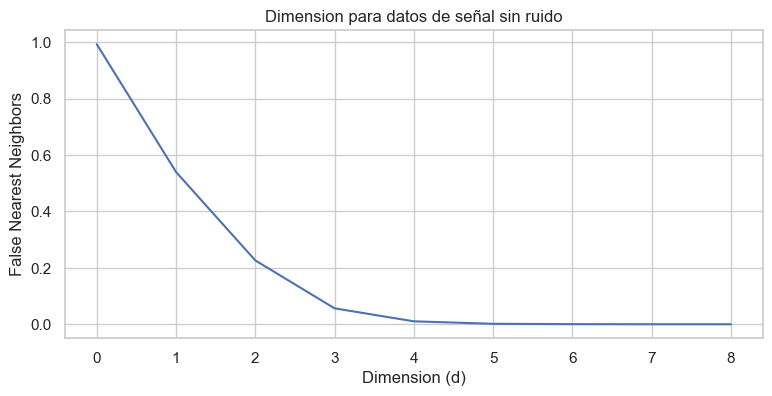

d:  7


In [13]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(ts_signal, tau=tau_ts_signal, dim=dim) #Ejemplo

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors')
plt.title("Dimension para datos de señal sin ruido")
plt.plot(f1)
plt.show()
print("d: ",find_optimal_dimension(ts_noise,tau_ts_noise))

Vamos a elegir la dimension 3.

### Aplicar el Encaje

In [14]:
stride = 25
dim =  3

#con ruido
embedder_noise = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay=tau_ts_noise, dimension=2, stride=stride
)

y_embedded_noise = embedder_noise.fit_transform(ts_noise)

In [15]:
#sin ruido
embedder_signal = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay= tau_ts_signal, dimension=2, stride=15
)

y_embedded_signal = embedder_signal.fit_transform(ts_signal)

In [16]:
plot_point_cloud(y_embedded_noise)

In [17]:
plot_point_cloud(y_embedded_signal)

### Analisis de persistencia

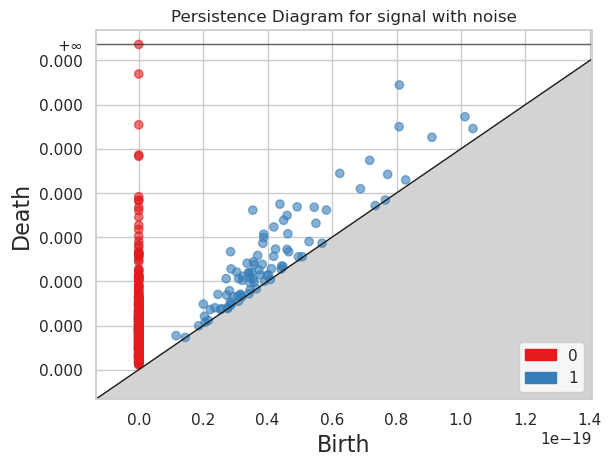

In [21]:
skeletonCirc_noise = gd.RipsComplex(points=y_embedded_noise, max_edge_length = 2)
Rips_simplex_tree_Circ_noise = skeletonCirc_noise.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_Circ_noise = Rips_simplex_tree_Circ_noise.persistence()
gd.plot_persistence_diagram(Barcodes_Rips_Circ_noise);
plt.title(f'Persistence Diagram for signal with noise')
plt.show()    

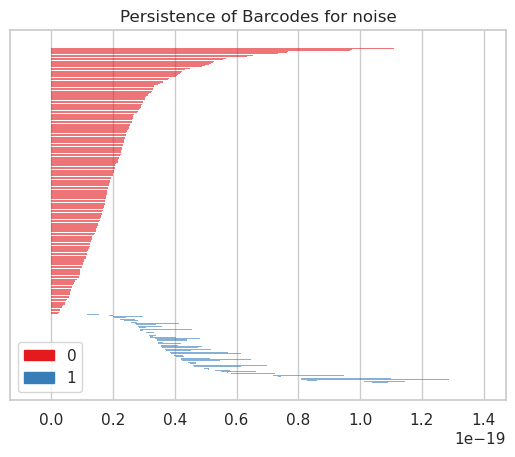

In [24]:
diag_inf = Rips_simplex_tree_Circ_noise.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf);
plt.title(f'Persistence of Barcodes for noise')
plt.show()

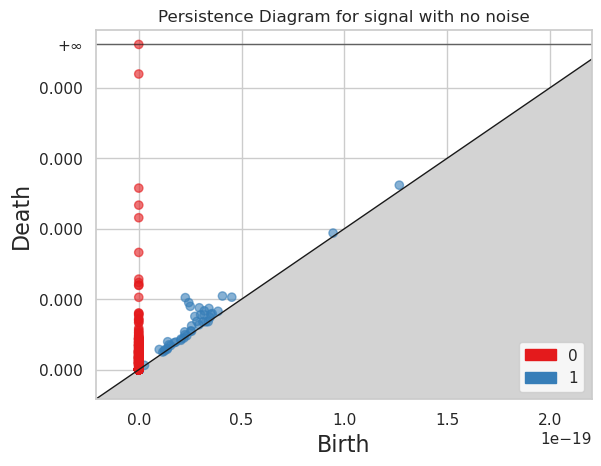

In [22]:
skeletonCirc_signal = gd.RipsComplex(points=y_embedded_signal, max_edge_length = 2)
Rips_simplex_tree_Circ_signal = skeletonCirc_signal.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_Circ_signal = Rips_simplex_tree_Circ_signal.persistence()
gd.plot_persistence_diagram(Barcodes_Rips_Circ_signal);
plt.title(f'Persistence Diagram for signal with no noise')
plt.show()    

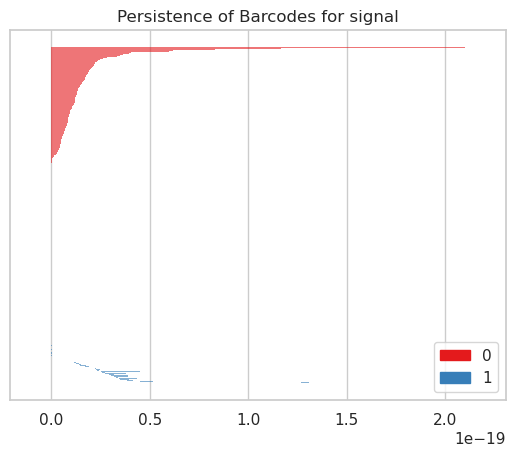

In [23]:
diag_inf = Rips_simplex_tree_Circ_signal.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf);
plt.title(f'Persistence of Barcodes for signal')
plt.show()

In [ ]:
#barcodes
#simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
#Notemos con esta paquetería se queda con lo más significativo si cambiamos la persistencia
#diag0 = simplex_tree.persistence(min_persistence=0)
#gudhi.plot_persistence_barcode(diag0)
#plt.show()

### Mapper